# Generative Pre-trained Transformer

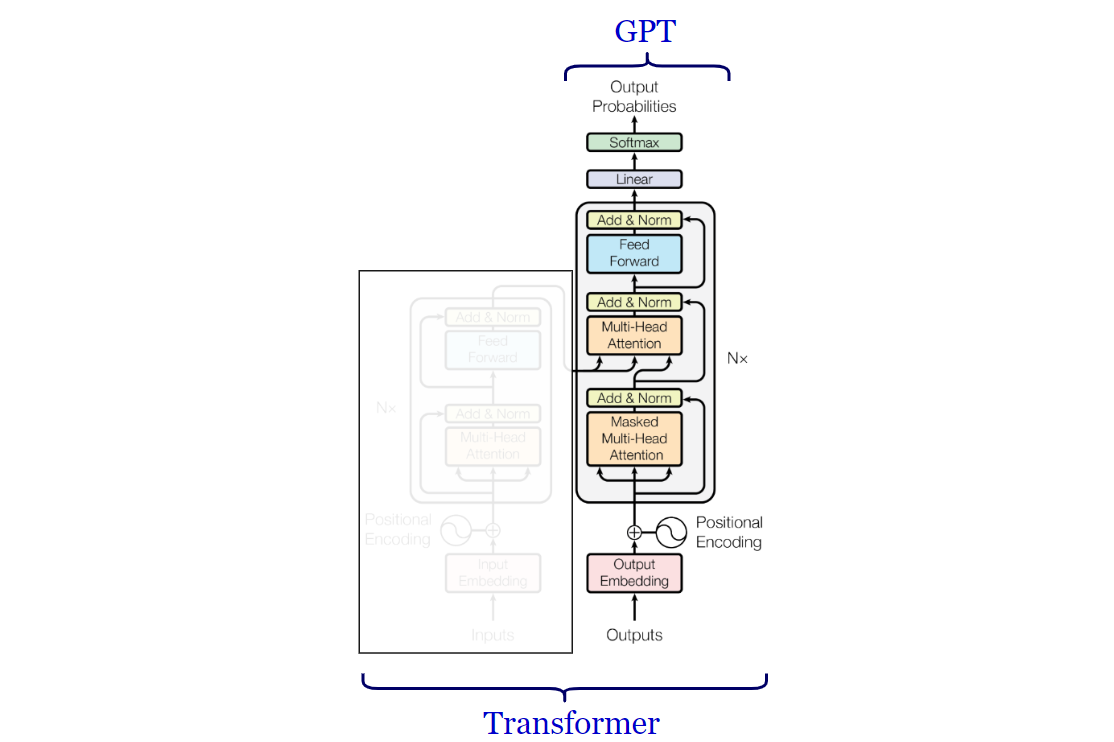

## Import Libraries

In [ ]:
import torch

import torch.nn as nn
from torch.nn import functional as F

## Reading Dataset

In [ ]:
torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

--2023-12-21 03:42:33--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-12-21 03:42:33 (20.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 100 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# **Data preprocessing**
The code's initial segment pre-processes input text by tokenizing it into a word list, assigning a unique integer to each word, and creating fixed-length sequences through a sliding window method.

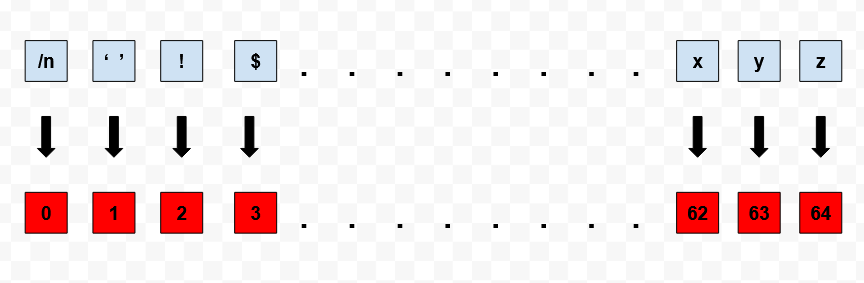

## Identifying unique characters that occur in a text

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(chars)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


### Mapping human-comprehensible text symbols to computer-comprehensible numbers

In [ ]:
#create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


## Encoding input data

In [ ]:
#let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earlier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


### Splitting up the data into train and validation sets

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be in train set, rest in val
train_data = data[:n]
val_data = data[n:]
block_size = 8 #which determines the input sequence size that the GPT model will process at a time
# train_data[:block_size+1]
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## Generating batches of input and target data for training the GPT

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
# generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
  for t in range(block_size): # time dimension
    context = xb[b, :t+1]
    target = yb[b,t]
    print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

# **Model configuration:**
This part of the code sets up the configuration parameters for the GPT model, specifying details such as the number of transformer layers, attention heads, hidden layer size, and vocabulary size.

## Hyperparameters:
- `batch_size`: Number of parallel sequences processed during training.
- `block_size`: Maximum context length for predictions.
- `max_iters`: Maximum training iterations for the GPT model.
- `eval_interval`: Interval for evaluating the model's performance during training.
- `learning_rate`: Learning rate for the optimizer during training.
- `device`: Device (CPU or GPU) for GPT model training.
- `eval_iters`: Evaluation and saving interval during training.
- `n_embd`: Number of embedding dimensions for the GPT model.
- `n_head`: Number of attention heads in the multi-head attention layer.
- `n_layer`: Number of layers in the GPT model.
- `dropout`: Dropout probability for regularization in the GPT model.



In [ ]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0


## Calculating the average loss on the training and validation datasets using a pre-trained model

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Model Architecture

The following code segments define the GPT model architecture using PyTorch modules. The model comprises an embedding layer, a series of transformer layers, and a linear layer responsible for producing the probability distribution over the vocabulary, determining the next word in the sequence.


## Defining one head of the self-attention mechanism in a transformer model


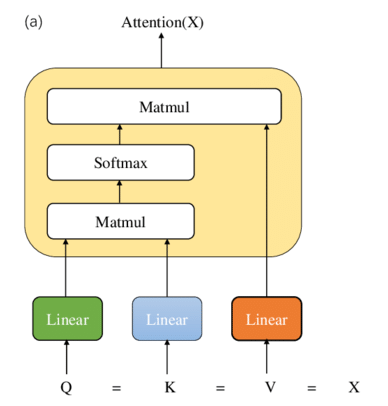

In [ ]:
class Head(nn.Module):
#""" one head of self-attention """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x) # (B,T,C)
    q = self.query(x) # (B,T,C)
    # compute attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)
    # perform the weighted aggregation of the values
    v = self.value(x) # (B,T,C)
    out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
    return out

### Implementing the multi-head attention mechanism

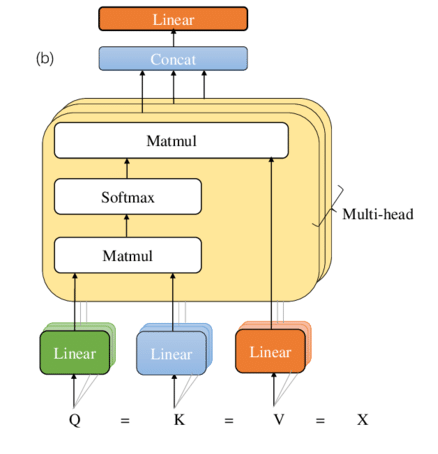

In [ ]:
class MultiHeadAttention(nn.Module):
#""" multiple heads of self-attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

### Next we need to add the FeedFoward module

In [ ]:
class FeedFoward(nn.Module):
#""" a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(n_embd, 4 * n_embd),
    nn.ReLU(),
    nn.Linear(4 * n_embd, n_embd),
    nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
#""" Transformer block: communication followed by computation """

  def __init__(self, n_embd, n_head):
  # n_embd: embedding dimension, n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedFoward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

### Model training and text generation

In [ ]:
class BigramLanguageModel(nn.Module):

  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx



In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


0.209729 M parameters
step 0: train loss 4.3474, val loss 4.3409
step 100: train loss 2.6516, val loss 2.6571
step 200: train loss 2.5088, val loss 2.5067
step 300: train loss 2.4191, val loss 2.4368
step 400: train loss 2.3515, val loss 2.3650
step 500: train loss 2.2973, val loss 2.3185
step 600: train loss 2.2372, val loss 2.2508
step 700: train loss 2.1971, val loss 2.2124
step 800: train loss 2.1637, val loss 2.1934
step 900: train loss 2.1219, val loss 2.1527
step 1000: train loss 2.0998, val loss 2.1356
step 1100: train loss 2.0605, val loss 2.1157
step 1200: train loss 2.0325, val loss 2.0855
step 1300: train loss 2.0161, val loss 2.0601
step 1400: train loss 1.9838, val loss 2.0348
step 1500: train loss 1.9620, val loss 2.0290
step 1600: train loss 1.9428, val loss 2.0333
step 1700: train loss 1.9372, val loss 2.0197
step 1800: train loss 1.9026, val loss 1.9983
step 1900: train loss 1.8929, val loss 1.9745
step 2000: train loss 1.8751, val loss 1.9916
step 2100: train loss 1.

In [ ]:
# generate from the model
context = torch.full((1, 1), 39, dtype=torch.long, device=device)

print(decode(m.generate(context, max_new_tokens=200)[0].tolist()))

ad.

KING RICHARD III:
Unciles! be what them are it, and dispitate old.

How:
Now be stome it benday, my lord a day that:
be I cry you
go sole out in a merder
At now the gone of ording thee, fric as fa
